### 3.5 The Image Classification Dataset

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import warnings
warnings.filterwarnings('ignore')

d2l.use_svg_display()

In [ ]:
stl_train = torchvision.datasets.STL10(root="../data", split='train', transform=transforms.ToTensor(), download=True)
stl_test = torchvision.datasets.STL10(root="../data", split='test', transform=transforms.ToTensor(), download=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ../data/stl10_binary.tar.gz to ../data
Files already downloaded and verified


In [ ]:
len(stl_train), len(stl_test)

(5000, 8000)

In [ ]:
stl_train[0][0].shape

torch.Size([3, 96, 96])

In [ ]:
stl_train.labels

array([1, 5, 1, ..., 1, 7, 5], dtype=uint8)

In [ ]:
def get_stl_labels(labels):  
    text_labels = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
    return [text_labels[int(i)] for i in labels]

In [ ]:
import numpy as np

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            img = img.numpy()
            ax.imshow(np.transpose(img,(1,2,0))) # rgb사진으로 보기 위한 방법 (하단 reference 1 참고)
   '''기본적으로 PyTorch는 이미지 데이터셋을 [Batch Size, Channel, Width, Height] 순서대로 저장하기 때문에, 
   이를 matplotlib로 출력하기 위해서는 각 이미지를 [Width, Height, Channel] 형태로 변경해 줄 필요가 있다. 
   그것은 numpy 라이브러리의 transpose() 함수를 이용하여 해결할 수 있다.  출처: https://ndb796.tistory.com/372 [안경잡이개발자:티스토리] '''
        else:
# PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

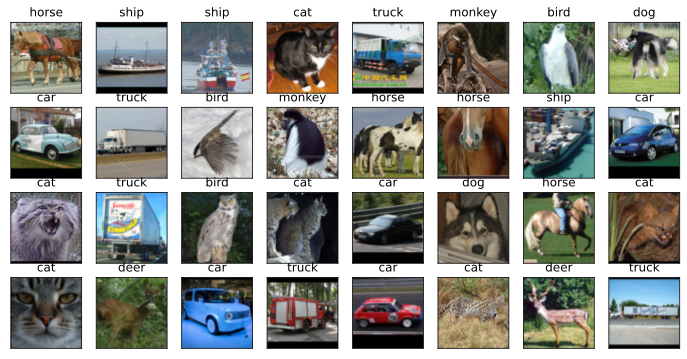

In [ ]:
X, y = next(iter(data.DataLoader(stl_train, batch_size=32, shuffle=True)))
show_images(X, 4, 8, titles=get_stl_labels(y)); # rgb 사진 출력 (reshape 해줄 필요 없음)

In [ ]:
batch_size = 256
def get_dataloader_workers(): 
    """Use 4 processes to read the data."""
    return 4
train_iter = data.DataLoader(stl_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [ ]:
timer = d2l.Timer()
for X, y in train_iter:
  continue
f'{timer.stop():.2f} sec'

'2.41 sec'

In [ ]:
def load_data_stl(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    stl_train = torchvision.datasets.STL10(root="../data", split='train', transform=trans, download=True)
    stl_test = torchvision.datasets.STL10(root="../data", split='test', transform=trans, download=True)
    return (data.DataLoader(stl_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(stl_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))

In [ ]:
train_iter, test_iter = load_data_stl(32, resize=64)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([32, 3, 64, 64]) torch.float32 torch.Size([32]) torch.int64


### 3.6 Implementation of Softmax Regression from Scratch


In [ ]:
import torch
from IPython import display
from d2l import torch as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = load_data_stl(batch_size, resize=64)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_inputs = 3*64*64   
num_outputs = 10 #label 개수 : 10개
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
for X, y in train_iter:
  print(X.shape)
  break

torch.Size([256, 3, 64, 64])


In [ ]:
for X, y in train_iter:
  n = X.reshape((-1, W.shape[0]))
  print(n.shape)
  break

torch.Size([256, 12288])


In [ ]:
for X, y in train_iter:
  n = torch.matmul(X.reshape((-1, W.shape[0])), W) + b
  print(n.shape)
  break

torch.Size([256, 10])


In [ ]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition  # The broadcasting mechanism is applied here

def net(X):
 # dense1 = torch.matmul(X.reshape((-1, W.shape[0])), W) + b
 # dense2 = torch.matmul(dense1,W)
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range (len(y_hat)), y])

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
evaluate_accuracy(net, test_iter)

0.0845

In [ ]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
  """The training loop defined in Chapter 3."""
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
    net.train()
# Sum of training loss, sum of training accuracy, no. of examples
  metric = Accumulator(3)
  for X, y in train_iter:
    # Compute gradients and update parameters
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.mean().backward()
        updater.step()
    else:
        # Using custom built optimizer & loss criterion
        l.sum().backward()
        updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
# Return training loss and training accuracy
  return metric[0]/metric[2] , metric[1]/metric[2]

In [ ]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
           if a is not None and b is not None:
             self.X[i].append(a)
             self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
          self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],legend=['train loss', 'train acc', 'test acc']) #성능이 너무 낮아서 ylim 제거
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    #assert train_loss < 0.5, train_loss
    #assert train_acc <= 1 and train_acc > 0.7, train_acc
    #assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

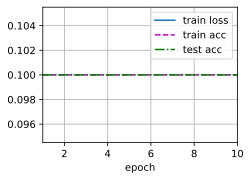

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

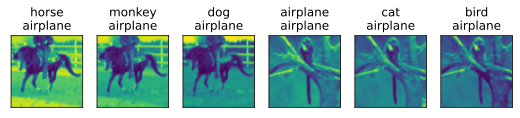

In [ ]:
def predict_ch3(net, test_iter, n=6):
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
      break
    trues = get_stl_labels(y)
    preds = get_stl_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n*3, 64, 64)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

### 3.7 Concise Implementation of Softmax Regression

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=64)

In [ ]:
# PyTorch does not implicitly reshape the inputs. Thus we define the flatten
# layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(3*64*64, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

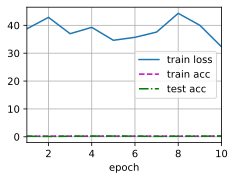

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer) #dense layer가 하나 뿐이라서 성능이 낮음. 따라서 ylim이 제거된 사용자 정의 함수 train_ch3 사용